In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#**Library Imports**

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# **Load & Visualize Images Per Class**

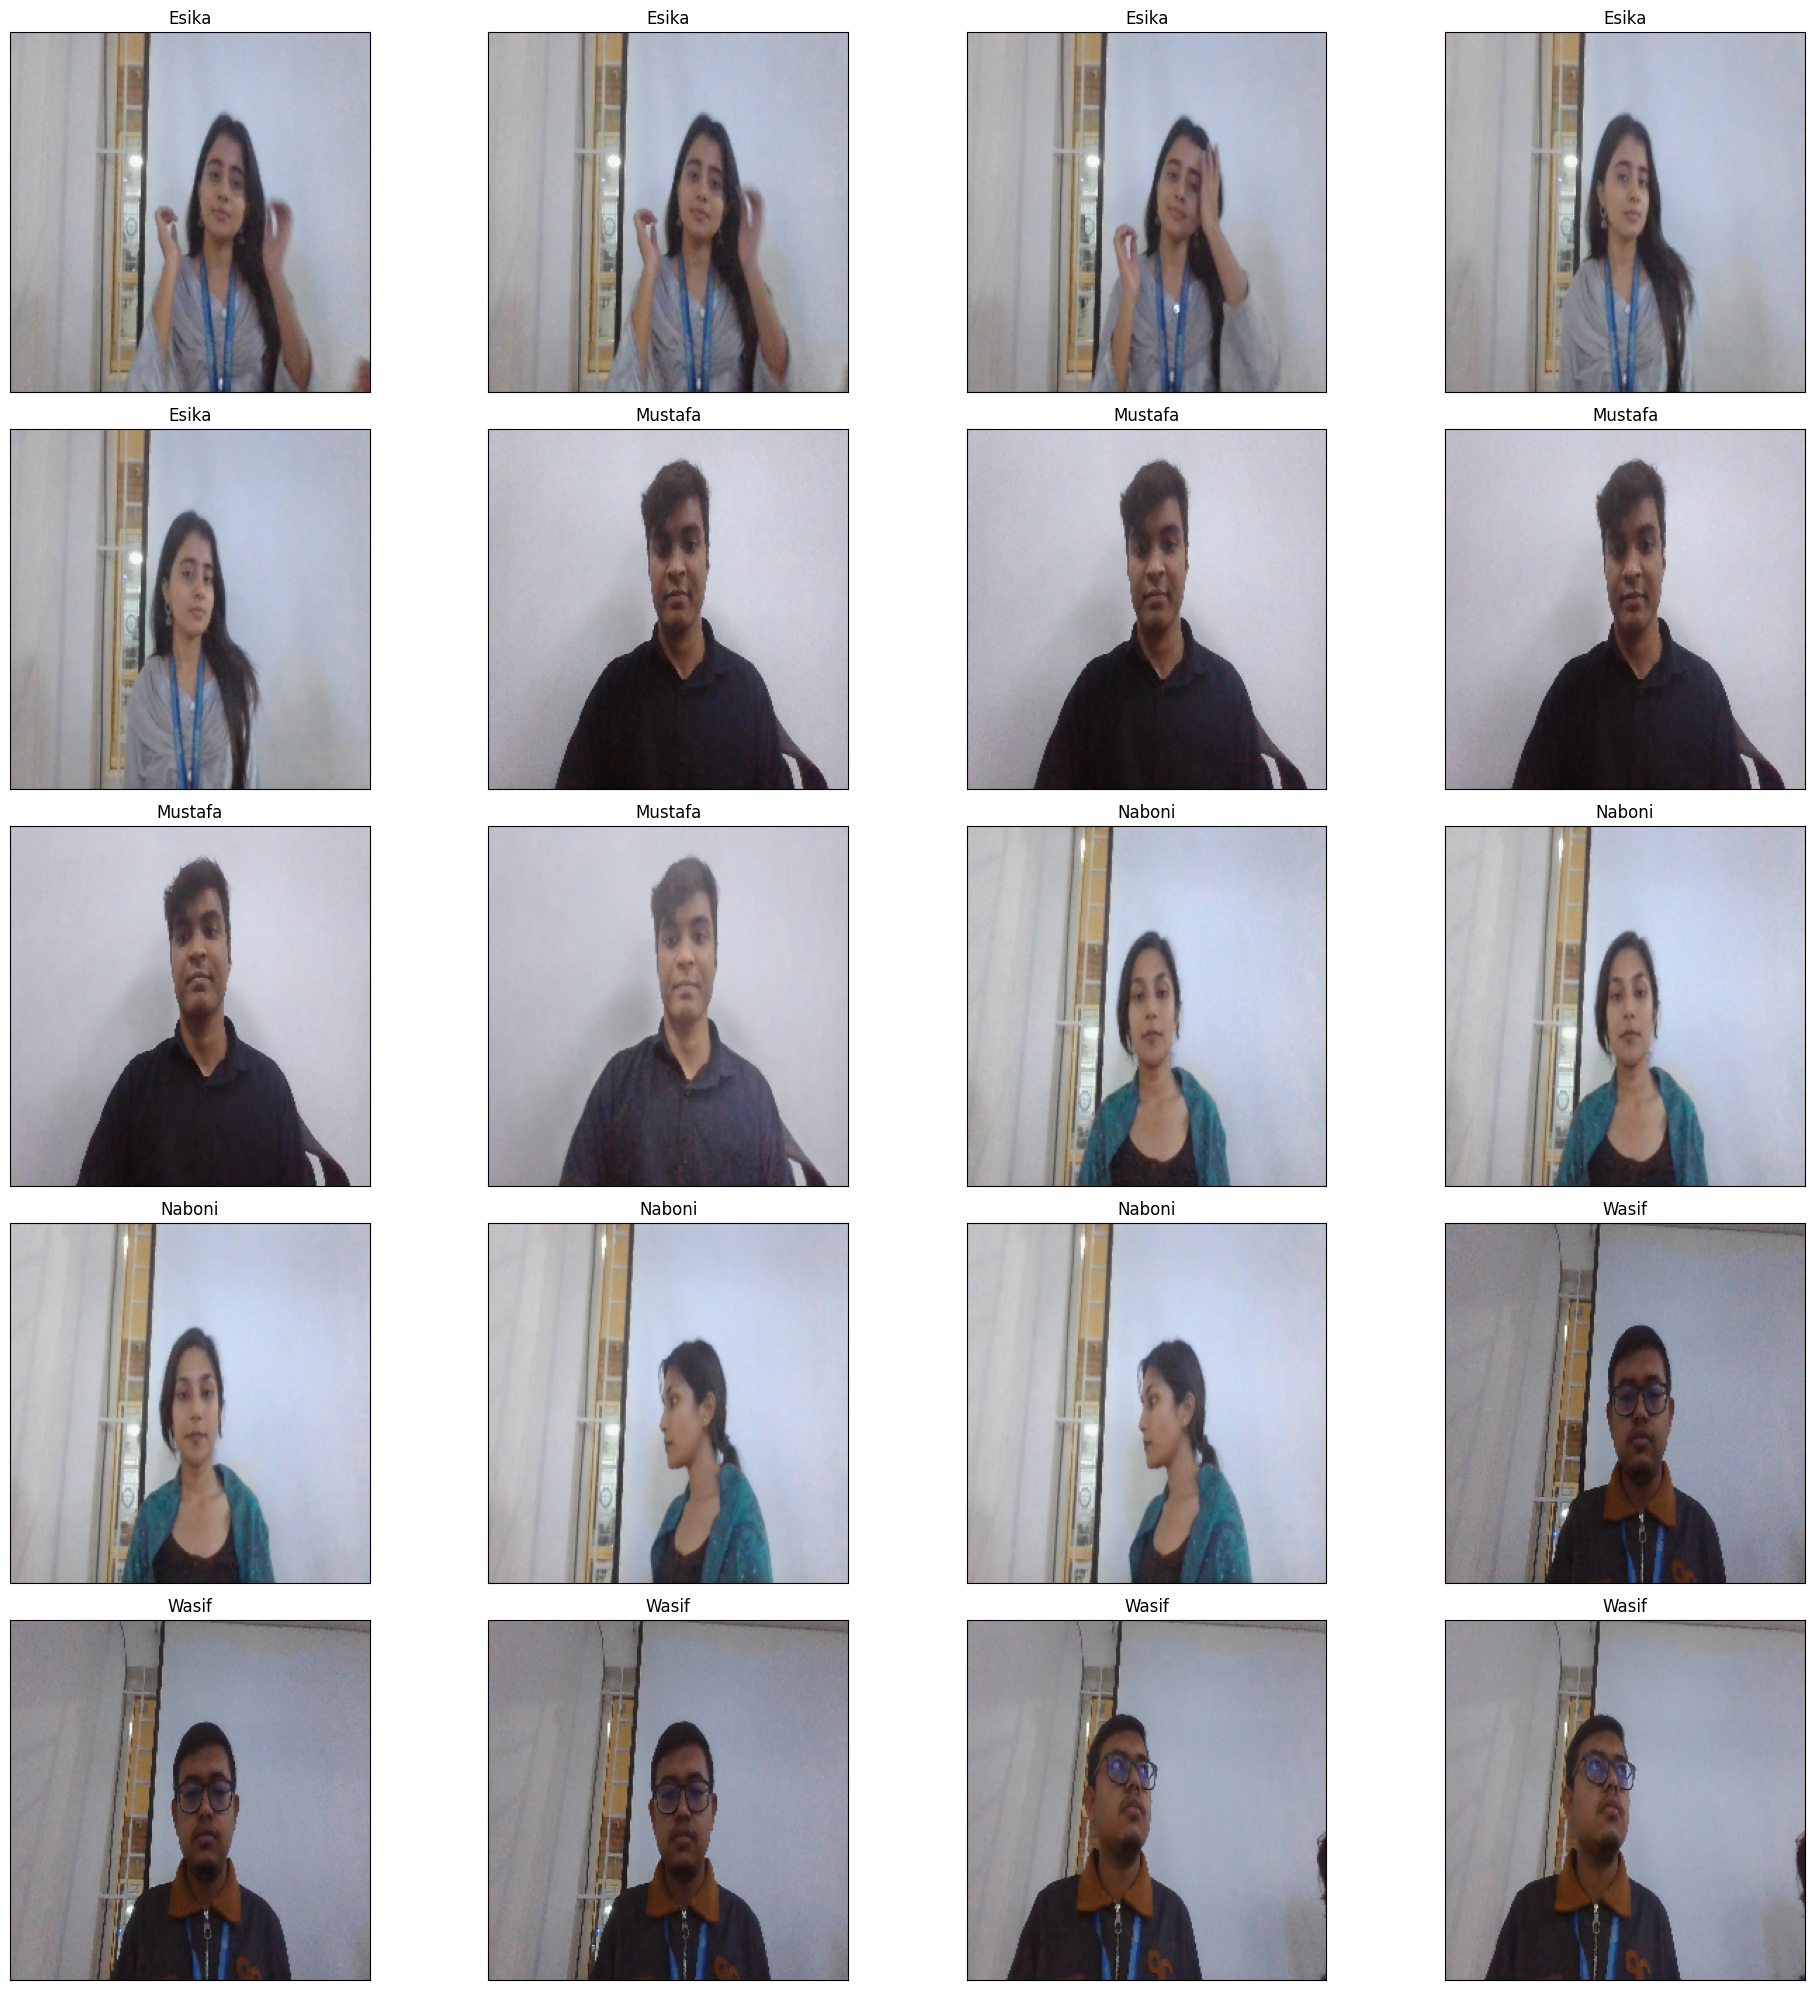

In [3]:
# Path to images folder
image_dir = '/content/drive/MyDrive/Images'

num_images_per_class = 5
class_names = sorted(os.listdir(image_dir))

# Store images and labels
selected_images = []
selected_labels = []


for class_name in class_names:
    class_path = os.path.join(image_dir, class_name)

    # Get image filenames from the folder
    image_files = sorted(os.listdir(class_path))[:num_images_per_class]  # Select first 5 images

    # Load images
    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        img = load_img(image_path, target_size=(256, 256))  # Resize images
        img_array = img_to_array(img) / 255.0  # Normalize

        selected_images.append(img_array)
        selected_labels.append(class_name)

# Convert to NumPy arrays
selected_images = np.array(selected_images)

total_images = len(selected_images)
num_cols = 4
num_rows = 5

# Plot images
plt.figure(figsize=(20, 20))
for i in range(total_images):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(selected_images[i])
    plt.title(selected_labels[i])
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

#**Data Split (Train/Test/Validation)**


In [4]:
# Dataset path
image_dir = '/content/drive/MyDrive/Images'

# Parameters
batch_size = 32
img_size = (256, 256)
SizePerClass = 400  # 400 images per class

# Load the dataset with validation split
train_data = image_dataset_from_directory(
    image_dir,
    validation_split=0.2,
    subset="training", # 80% for training
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

valid_data = image_dataset_from_directory(
    image_dir,
    validation_split=0.2,
    subset="validation", # 20% for validation
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# Check class names
class_names = train_data.class_names
num_classes = len(class_names)
print("Class Names:", class_names)

Found 4448 files belonging to 4 classes.
Using 3559 files for training.
Found 4448 files belonging to 4 classes.
Using 889 files for validation.
Class Names: ['Esika', 'Mustafa', 'Naboni', 'Wasif']


In [5]:
# Limit dataset size
max_batches = SizePerClass // batch_size

# Reduce training and validation datasets
train_data = train_data.take(max_batches)
valid_data = valid_data.take(max_batches // 2)  # Smaller validation set

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.prefetch(buffer_size=AUTOTUNE)

#**Data Augmentation**

In [6]:
# Data Augmentation Layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Apply data augmentation to the training set
train_data = train_data.map(lambda x, y: (data_augmentation(x), y))

# **Load Pretrained Model (EfficientNet)**

In [7]:
# Load EfficientNetB0
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

# Add Custom Layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(num_classes, activation='softmax')(x)

# Build Model
model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 256, 256, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 256, 256, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 257, 257, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 128, 128, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 128, 128, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 128, 128, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 128, 128, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 128, 128, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 128, 128, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,378,535 (16.70 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [8]:
# Early Stopping
cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=10,
    callbacks=[cb],
    verbose=1
)

# Save the model
model.save("/content/TransferLearning_EfficientnetModel.h5")


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 98s 6s/step - accuracy: 0.3339 - loss: 1.3727 - val_accuracy: 0.7552 - val_loss: 0.8529
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 70s 6s/step - accuracy: 0.7132 - loss: 0.8111 - val_accuracy: 0.9479 - val_loss: 0.5030
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 92s 8s/step - accuracy: 0.9166 - loss: 0.5156 - val_accuracy: 0.9948 - val_loss: 0.3427
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 69s 6s/step - accuracy: 0.9470 - loss: 0.3692 - val_accuracy: 0.9896 - val_loss: 0.2331
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 73s 6s/step - accuracy: 0.9821 - loss: 0.2538 - val_accuracy: 0.9896 - val_loss: 0.1582
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 68s 6s/step - accuracy: 0.9869 - loss: 0.2031 - val_accuracy: 0.9948 - val_loss: 0.1087
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 80s 7s/step - accuracy: 0.9825 - loss: 0.1475 - val_accuracy: 1.0000 - val_loss: 0.1077
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 76s 6s/step - accuracy: 0.9967 - loss: 0.1157 - val_accuracy: 1.0000 - val_loss:

#**Evaluate and Visualize Predictions**

6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 1.0000 - loss: 0.0546

Accuracy: 1.0000
Loss: 0.0491
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


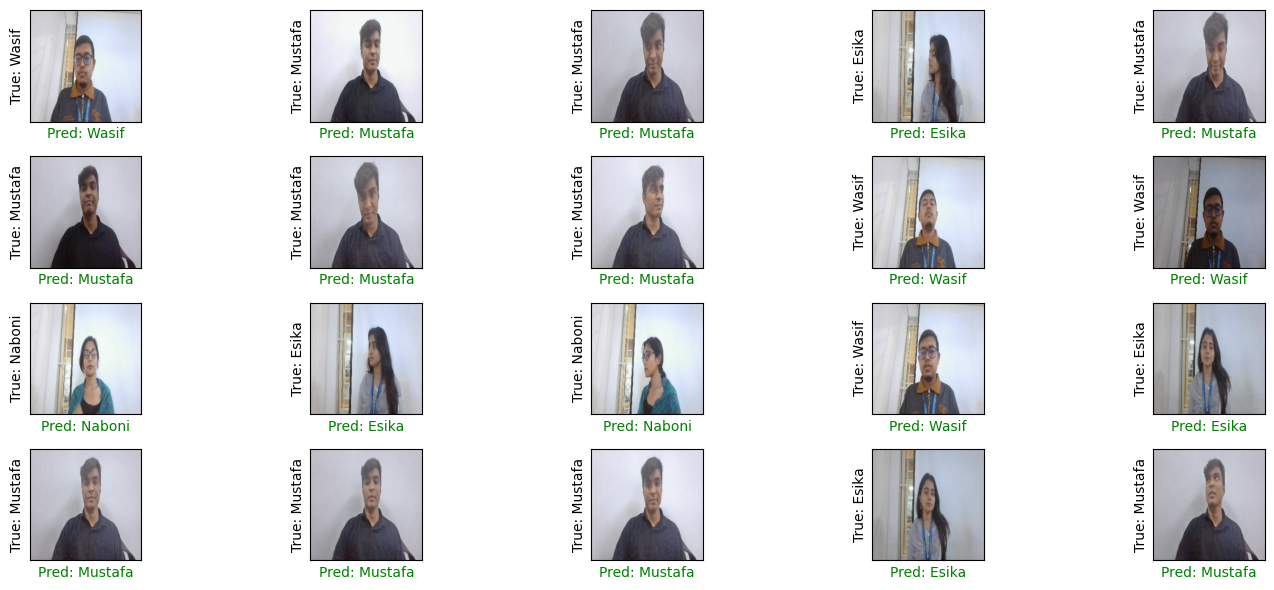

In [9]:
# Evaluate the model
test_loss, test_acc = model.evaluate(valid_data)
print(f'\nAccuracy: {test_acc:.4f}')
print(f'Loss: {test_loss:.4f}')

# Predict on a batch
test_images, test_labels = next(iter(valid_data.take(1)))
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Plot results (Visualize predictions)
plt.figure(figsize=(15, 6))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(test_images[i].numpy().astype("uint8"))
    plt.xticks([])
    plt.yticks([])

    true_label = class_names[test_labels[i].numpy()]
    predicted_label = class_names[predicted_labels[i]]

    color = 'green' if true_label == predicted_label else 'red'
    plt.xlabel(f"Pred: {predicted_label}", color=color)
    plt.ylabel(f"True: {true_label}")

plt.tight_layout()
plt.show()
